In [1]:
from pathlib import Path
import os
import shutil
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
from datetime import datetime
from scipy.optimize import minimize, differential_evolution, basinhopping
from scipy.interpolate import interp1d
from pandas import Series, DataFrame
import pandas as pd
import teslamax
from teslamax import TeslaMaxGeometry, TeslaMaxPreDesign, TeslaMaxModel

In [2]:
plt.set_cmap(cmap="Greys")

<Figure size 432x288 with 0 Axes>

In [3]:
import nemplot
from nemplot import nemplot_parameters

In [4]:
nemplot.set_dpi(800)
nemplot.set_figsize_cm(12)
nemplot.set_fontsize(14)
nemplot.set_latex_font("Palatino")
nemplot.set_plot_extension('.pdf')

nemplot.set_main_path(".")
nemplot.set_figures_dir('figures')

In [5]:
B_HIGH_LIMIT = 1.4

TESLAMAX_PATH = Path.home() / "code" / "TeslaMax"

PLAYGROUND_DIR = "teslamax-play"

RAMP_RESULTS_DIR_FMT = "ramp_Bh_%d_FM_%d"

TESLAMAX_MPH_DIR = TESLAMAX_PATH / "java"

TESLAMAX_FILENAME = "TeslaMax_Model"
TESLAMAX_FILE_EXT = "mph"

TESLAMAX_FILE_STR = str(TESLAMAX_MPH_DIR / (TESLAMAX_FILENAME + "." + TESLAMAX_FILE_EXT))


TESLAMAX_PLAYGROUND = TESLAMAX_PATH / PLAYGROUND_DIR

In [6]:
DICT_LINES = 19
K_CRITIC = 0.002
K_STEP = 0.002

# Default mesh parameters
L_ELEMENT_MAX_DEFAULT = 0.0111  # [m]
L_ELEMENT_MIN_DEFAULT = 3.75e-5  # [m]
N_NARROW_DEFAULT = 5

B_LABEL = r'$B\ped{max}\,[\si{\tesla}]$'
Q_LABEL = r'$\qc\,[\si{\watt}]$'
COP_LABEL = r'$\cop$'
PHI_LABEL = r'$\Phi$'
H_REG_LABEL = r'$H\ped{r}\,[\si{\milli\meter}]$'
H_GAP_LABEL = r'$h\ped{gap}\,[\si{\milli\meter}]$'
F_B_LABEL = r'$F\ped{B}\,[\si{\percent}]$'
F_M_LABEL = r'$F\ped{M}\,[\si{\percent}]$'
H_MAX_LABEL = r'$\mu_0 H\ped{max}\,[\si{\tesla}]$'

In [7]:
os.getcwd()

'C:\\Users\\fabiofortkamp\\code\\TeslaMax'

In [8]:
def optimize_ramp_with_timestamp(B_high,field_fraction,params,filename=None):
    """
    Run the TeslaMax optimization procedure, trying to match the profile
    to a ramp profile between 0 and 'B_high' with 'field_fraction', using the
    parameters in the dictionary 'params'.
    
    Return a TeslaMaxModel object, representing the optimized magnet,
    and the value of the cost function. The TeslaMaxModel object is already populated with simulation results.
    
    The simulation results are stored in directories inside PLAYGROUND_DIR.
    The COMSOL model file is saved as 'filename' (with '.mph' extension) in TESLAMAX_MPH_DIR, 
    if provided.
    """
    
    tmpd = TeslaMaxPreDesign(params)
    
    target_function = teslamax.calculate_ramp_profile

    
    target_args = (B_high,B_LOW,field_fraction)

    alpha_B_rem_g = tmpd.get_optimal_remanence_angles(target_function,target_args)
    cost_function = tmpd.calculate_functional_target(alpha_B_rem_g,
                                                    target_function,
                                                    target_args)
    
    tstamp = datetime.now().strftime("%Y%m%d%H%M%S")
    
    teslamax_playground = str(TESLAMAX_PATH / PLAYGROUND_DIR / tstamp  )
    
    tmm_g = TeslaMaxModel(tmpd,
                          alpha_B_rem_g,
                          path=teslamax_playground)
    tmm_g.run()
    
    if filename:
        shutil.copy(src=TESLAMAX_FILE_STR,
                    dst=str(TESLAMAX_MPH_DIR / (filename + "." + TESLAMAX_FILE_EXT)))
    
    return (tmm_g,cost_function)
    

In [9]:
FIXED_PARAMETERS_MAGNET = {"R_i": 0.030,
                "R_o": 0.185,
                "h_fc": 0.030,
                "R_s": 300e-3,
                "h_gap": 30e-3,
                "R_e": 1.0,
                "n_II": 0,
                "n_IV": 4,
                "B_rem_IV_1": 1.37,
                "B_rem_IV_2": 1.37,
                "B_rem_IV_3": 1.37,
                "B_rem_IV_4": 1.26,
                "phi_C_II": 0,
                "phi_S_IV": 45,
                "phi_S_II": 0,
                "mu_r_II": 1.05,
                "mu_r_IV": 1.05,
              "linear_iron": 1,
              "mu_r_iron": 5e3,
                "Hc_j": 1000e3,
              "l_element_min": L_ELEMENT_MIN_DEFAULT,
              "l_element_max": L_ELEMENT_MAX_DEFAULT,
              "n_narrow": N_NARROW_DEFAULT
             }

B_HIGH = 1.3
B_LOW = 0.0
F_M = 0.25

n_II = FIXED_PARAMETERS_MAGNET["n_II"]
n_IV = FIXED_PARAMETERS_MAGNET["n_IV"]
n = n_II + n_IV

In [10]:
def refine_list(original_list, factor):
    """
    Return a new list, inserting more elements between the number in 'original_list'.
    
    Assumes 'original_list' is evenly-spaced. The spacing between each element is divided by 'factor'
    
    >>>refine_list([1,2,3],factor=2)
    [1.0,1.5,2.0,2.5,3.0]
    """
    
    # calculate the original spacing between elements and refine it
    d = original_list[1] - original_list[0]
    d_refined = d / factor
        
    max_value = max(original_list)
    min_value = min(original_list)
    
    # the number of elements is the number of divisions between the limit values, plus one aditional
    n_refined = ((max_value - min_value) / d_refined) + 1
        
    return np.linspace(min_value,max_value,int(n_refined))

In [11]:
fractions_phi_S = [[25,25,25,25],
                   [50,20,15,15],
                   [50,30,15,5]]

In [12]:
os.chdir(TESLAMAX_PATH)

p = FIXED_PARAMETERS_MAGNET.copy()
    
results_list = []

for i, fractions in enumerate(fractions_phi_S):
    
    delta_phi_S_values = np.array(fractions)/100 * p["phi_S_IV"]
        
    p.update(
    {
        "delta_phi_S_IV_%d" %(j+1): (delta_phi_S_values[j]) for j in range(n_IV)
    }
    )
            
    
    tmm_magnet, K_magnet = optimize_ramp_with_timestamp(B_HIGH,F_M,p)
        
    results_list.append((tmm_magnet,K_magnet))

C:\Users\fabiofortkamp\Anaconda3\envs\teslamax\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


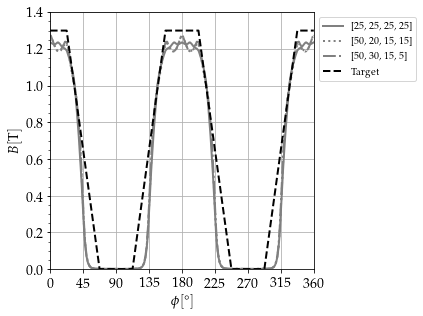

In [13]:
profile_fig_g, profile_axes_g = nemplot.create_plot(xlabel=r'$\phi [\si{\degree}]$',
                                                       ylabel=r'$B [\si{\tesla}]$')
lw = 2.0

linestyles = ['-', ':', '-.']
for i, fractions in enumerate(fractions_phi_S):

    (tmm_magnet, K_magnet) = results_list[i]

    phi_vector, B_vector = tmm_magnet.get_profile_data()

    label_str = str(fractions)
    profile_axes_g.plot(phi_vector,B_vector,
                        color='gray',
                        linestyle=linestyles[i],
                        linewidth=lw,label=label_str)

profile_axes_g.set_xlim(0,np.max(phi_vector))
profile_axes_g.set_xticks(np.linspace(0,np.max(phi_vector),9))
profile_axes_g.grid(True)
profile_axes_g.set_ylim(0,B_HIGH_LIMIT)

ticks = profile_axes_g.get_yticks()
profile_axes_g.set_yticks(refine_list(ticks,4),minor=True)

B_target_vector = teslamax.calculate_ramp_profile(phi_vector,B_HIGH,B_LOW,F_M)
profile_axes_g.plot(phi_vector,B_target_vector,'--',color='k',linewidth=lw,label="Target")

profile_axes_g.legend(loc='upper left',bbox_to_anchor=(1.0,1.0))

nemplot.save_figure(profile_fig_g,"profile_comparison_fractions")